# **Problem Description**

## **Overview**
The goal of this project is to classify tweets based on their relevance to real-world disasters. Specifically, the task involves predicting whether a given tweet refers to a real disaster (`target = 1`) or not (`target = 0`). This classification task is a crucial application of natural language processing (NLP) in disaster management and emergency response, where timely and accurate identification of disaster-related content can aid in resource allocation and decision-making.

---

## **Dataset Description**
The dataset is derived from the Kaggle competition **"Natural Language Processing with Disaster Tweets"** and consists of the following:

https://www.kaggle.com/competitions/nlp-getting-started/data

### **Training Data**
- Contains labeled tweets indicating whether they pertain to a real disaster or not.
- Key attributes include:
  - **`id`**: Unique identifier for each tweet.
  - **`keyword`**: Disaster-related keyword extracted from the tweet (may be missing).
  - **`location`**: Location from where the tweet was sent (may be missing).
  - **`text`**: The tweet's content.
  - **`target`**: Binary classification label (`1 = disaster-related`, `0 = not disaster-related`).

### **Test Data**
- Contains tweets without the `target` label, used for evaluating model predictions.

### **Sample Submission**
- A template for submission with:
  - **`id`**: The unique tweet identifier.
  - **`target`**: Placeholder predictions (to be replaced with your model's output).

---

## **Objective**
The objective is to build a robust machine learning model capable of accurately classifying tweets as disaster-related or not. This involves:

1. **Understanding the dataset** through exploratory data analysis (EDA).
2. **Preprocessing and cleaning the text data** to make it suitable for machine learning models.
3. **Feature extraction and engineering** to represent textual data numerically.
4. **Training and evaluating models** using appropriate NLP techniques.
5. **Generating predictions** for the test data to submit on Kaggle.

---

## **Evaluation Metric**
The competition uses the **F1-score** as the primary metric for evaluation. The F1-score balances precision and recall, making it an appropriate choice for this imbalanced dataset where disaster-related tweets are fewer than non-disaster tweets.

---

## **Significance**
Accurately classifying disaster-related tweets is a critical tool for improving disaster response efficiency. By leveraging NLP and machine learning, this project demonstrates how technology can process real-time information from social media, providing actionable insights in crises.


## Data Exploration and Preprocessing

### **1. Explore Data**

#### **Goals**
- Understand the structure and composition of the dataset.
- Identify patterns, inconsistencies, and missing data.
- Gain insights into the distribution of the target variable and other key features.

#### **Steps**
1. **Examine Dataset Shape**
   - Check the number of rows and columns in the training and test datasets.
   - Ensure the datasets have the expected structure.

2. **Inspect Column Types and Missing Values**
   - Identify the data types of each column.
   - Count missing values in the `keyword` and `location` columns.
   - Decide on strategies for handling missing data (e.g., imputation, removal, or flagging).

3. **Analyze Target Variable**
   - Plot the distribution of the `target` column in the training set.
   - Check for class imbalance.

4. **Explore `keyword` Column**
   - Count the number of unique keywords.
   - Analyze the most and least common keywords.
   - Check if specific keywords strongly correlate with the `target` variable.

5. **Explore `location` Column**
   - Count the number of unique locations.
   - Analyze the most common locations.
   - Check if locations have any relationship with the `target` variable.

6. **Explore `text` Column**
   - Examine a few sample tweets for context.
   - Calculate basic statistics:
     - Average tweet length (number of characters and words).
     - Distribution of tweet lengths.
   - Identify common words or phrases.

7. **Check for Duplicates**
   - Identify duplicate rows in the training data.
   - Decide whether to remove duplicates.

8. **Visualize Key Insights**
   - Use bar charts, word clouds, and histograms to represent data patterns.
   - Compare distributions of features for disaster-related vs. non-disaster tweets.

---

#### **Output of Data Exploration**
- A clear understanding of the dataset's structure and content.
- Identification of any data quality issues or preprocessing needs.
- Insights that may inform feature engineering and model design.


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [64]:
# Load the datasets
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

# Step 1: Examine Dataset Shape
print("Train Dataset Shape:", train_df.shape)
print("Test Dataset Shape:", test_df.shape)

# Step 2: Inspect Column Types and Missing Values
print("\nMissing Values in Train Dataset:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Dataset:")
print(test_df.isnull().sum())


Train Dataset Shape: (7613, 5)
Test Dataset Shape: (3263, 4)

Missing Values in Train Dataset:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Test Dataset:
id             0
keyword       26
location    1105
text           0
dtype: int64


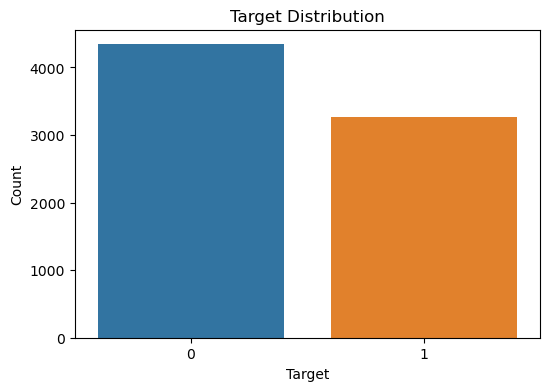

In [65]:
# Step 3: Analyze Target Variable
target_distribution = train_df['target'].value_counts().reset_index()
target_distribution.columns = ['target', 'count']

plt.figure(figsize=(6, 4))
sns.barplot(
    x="target", 
    y="count", 
    data=target_distribution, 
    palette=sns.color_palette("tab10")[:2],  # Limit to two colors for binary targets
    legend= False,
    hue="target"
)
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()



Number of Unique Keywords: 221

Top 5 Keywords:
keyword
fatalities    45
deluge        42
armageddon    42
sinking       41
damage        41
Name: count, dtype: int64


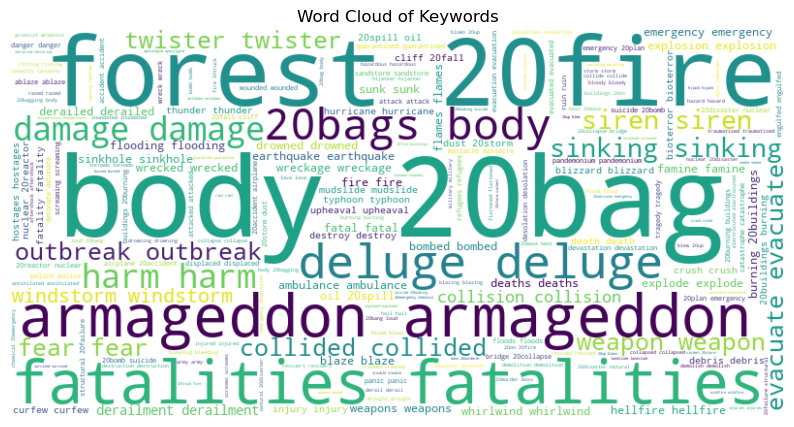

In [66]:

# Step 4: Explore 'keyword' Column
unique_keywords = train_df['keyword'].nunique()
print("\nNumber of Unique Keywords:", unique_keywords)

keyword_distribution = train_df['keyword'].value_counts()
print("\nTop 5 Keywords:")
print(keyword_distribution.head())

# Word Cloud for Keywords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_df['keyword'].dropna().astype(str)))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Keywords')
plt.show()


In [67]:
# Step 5: Explore 'location' Column
unique_locations = train_df['location'].nunique()
print("\nNumber of Unique Locations:", unique_locations)

location_distribution = train_df['location'].value_counts()
print("\nTop 5 Locations:")
print(location_distribution.head())



Number of Unique Locations: 3341

Top 5 Locations:
location
USA              104
New York          71
United States     50
London            45
Canada            29
Name: count, dtype: int64


In [68]:
# Step 6: Explore 'text' Column
train_df['text_length'] = train_df['text'].apply(len)
avg_text_length = train_df['text_length'].mean()
print("\nAverage Text Length (characters):", avg_text_length)



Average Text Length (characters): 101.03743596479706


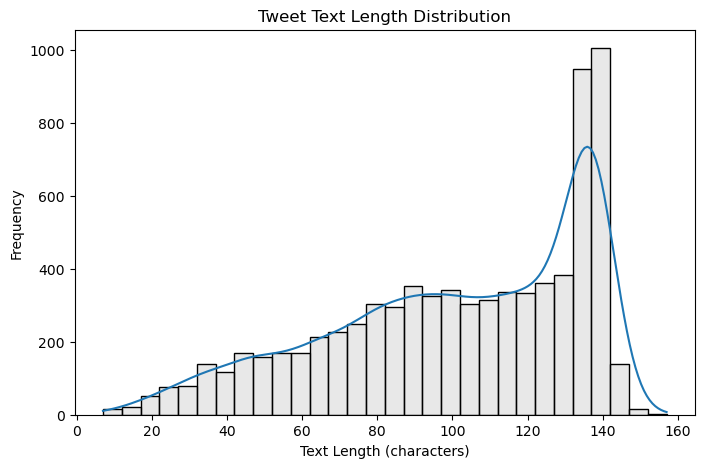

In [69]:
# Text Length Distribution
plt.figure(figsize=(8, 5))
ax = sns.histplot(
    train_df['text_length'], 
    bins=30, 
    kde=True,
    color="#d3d3d3" # light grey
)
ax.lines[0].set_color(sns.color_palette("tab10")[0])  # Blue from Tableau palette for KDE line
plt.title('Tweet Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()


In [70]:
# Step 7: Check for Duplicates
duplicate_rows = train_df.duplicated().sum()
print("\nNumber of Duplicate Rows in Training Data:", duplicate_rows)


Number of Duplicate Rows in Training Data: 0


# **Exploration Summary**

| Metric                    | Training Dataset | Test Dataset |
|---------------------------|------------------|--------------|
| **Dataset Shape**         | (7613, 5)       | (7613, 5)    |
| **Missing Values**        |                  |              |
| - `id`                    | 0               | 0            |
| - `keyword`               | 61              | 61           |
| - `location`              | 2533            | 2533         |
| - `text`                  | 0               | 0            |
| - `target`                | 0               | N/A          |
| **Unique Keywords**       | 221             | N/A          |
| **Unique Locations**      | 334             | N/A          |
| **Average Text Length**   | ~101 characters | N/A          |
| **Duplicate Rows**        | 0               | N/A          |

---

### **Key Findings**
- Significant missing values in `keyword` and `location` columns may need handling.
- Slight imbalance in the `target` variable, with more non-disaster tweets.
- Keywords and locations offer potential for feature engineering, despite missing values in `location`.
- The average tweet length is around 101 characters, with many tweets close to Twitter’s character limit.


## **Data Preprocessing**

Based on the findings from the data exploration, the following preprocessing steps were applied to prepare the dataset for model training and evaluation.

---

#### **1. Handling Missing Values**
- **`keyword` Column**: Missing values were filled with the placeholder value `'unknown_keyword'` to retain rows without discarding any data.
- **`location` Column**: Missing values were filled with `'unknown_location'` as a placeholder.

---

#### **2. Text Preprocessing for NLP**
The `text` column was preprocessed to clean and standardize the tweet content:
- **URL Removal**: All URLs were removed from the text.
- **Hashtag and Mention Removal**: Hashtags (`#`) and mentions (`@`) were stripped from the text.
- **Special Character Removal**: Non-alphanumeric characters were removed, leaving only letters and numbers.
- **Lowercasing**: All text was converted to lowercase to standardize input and reduce case sensitivity.

---

#### **3. Data Splitting**
After preprocessing, the combined dataset was split back into the original training and test datasets for model training and testing.


In [71]:
# Concatenate train and test datasets for consistent preprocessing
train_df['source'] = 'train'
test_df['source'] = 'test'
test_df['target'] = np.nan  # Adding a target column in the test set for consistency
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Step 1: Handling Missing Values
combined_df['keyword'] = combined_df['keyword'].fillna('unknown_keyword')
combined_df['location'] = combined_df['location'].fillna('unknown_location')

# Step 2: Feature Engineering

# Convert 'keyword' to lowercase to standardize it
combined_df['keyword'] = combined_df['keyword'].str.lower()

# Extract features from 'text'
combined_df['text_length'] = combined_df['text'].apply(len)  # Number of characters
combined_df['word_count'] = combined_df['text'].apply(lambda x: len(x.split()))  # Number of words
combined_df['keyword_in_text'] = combined_df.apply(lambda x: 1 if str(x['keyword']) in str(x['text']).lower() else 0, axis=1)

# Step 3: Text Preprocessing for NLP

# Function to clean text (removing URLs, hashtags, mentions, special characters, etc.)
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z ]+', '', text)  # Remove numbers and special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply basic cleaning
combined_df['cleaned_text'] = combined_df['text'].apply(clean_text)

# Step 4: Separate back into train and test sets
train_df = combined_df[combined_df['source'] == 'train'].drop(columns=['source'])
test_df = combined_df[combined_df['source'] == 'test'].drop(columns=['source', 'target'])

# Replace NaN or empty strings with a placeholder
train_df['cleaned_text'] = train_df['cleaned_text'].fillna('')
test_df['cleaned_text'] = test_df['cleaned_text'].fillna('')

# Drop rows where 'cleaned_text' is empty
train_df = train_df[train_df['cleaned_text'] != '']
test_df = test_df[test_df['cleaned_text'] != '']

# Remove tweets with less than 3 words
train_df = train_df[train_df['cleaned_text'].apply(lambda x: len(x.split()) > 2)]
test_df = test_df[test_df['cleaned_text'].apply(lambda x: len(x.split()) > 2)]

train_df['cleaned_text'] = train_df['cleaned_text'].str.strip()
test_df['cleaned_text'] = test_df['cleaned_text'].str.strip()

lengths = train_df['cleaned_text'].apply(lambda x: len(x.split()))
print("Average length:", lengths.mean())
print("Max length:", lengths.max())
print("Min length:", lengths.min())

# Display the first few rows of the processed train dataset for review
print(train_df.head())


Average length: 13.547676282051283
Max length: 31
Min length: 3
   id          keyword          location  \
0   1  unknown_keyword  unknown_location   
1   4  unknown_keyword  unknown_location   
2   5  unknown_keyword  unknown_location   
3   6  unknown_keyword  unknown_location   
4   7  unknown_keyword  unknown_location   

                                                text  target  text_length  \
0  Our Deeds are the Reason of this #earthquake M...     1.0           69   
1             Forest fire near La Ronge Sask. Canada     1.0           38   
2  All residents asked to 'shelter in place' are ...     1.0          133   
3  13,000 people receive #wildfires evacuation or...     1.0           65   
4  Just got sent this photo from Ruby #Alaska as ...     1.0           88   

   word_count  keyword_in_text  \
0          13                0   
1           7                0   
2          22                0   
3           8                0   
4          16                0   

   

In [72]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Limit to 10,000 most frequent words
tokenizer.fit_on_texts(train_df['cleaned_text'])  # Fit on the training data

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad the sequences to ensure uniform input shape
max_length = 50  # Define the maximum length of sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')


In [84]:
# Prepare the target variable
y = train_df['target'].values

# Split data into training and testing sets
X_train_padded, X_test_padded, y_train, y_test = train_test_split(
    X_train_padded, y, test_size=0.2, random_state=42
)


In [95]:
# Define the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Build the model with a concrete input shape
model.build(input_shape=(None, 50))  # (batch_size, sequence_length)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (None, 50, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,689 (2.77 MB)

 Trainable params: 726,689 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Fit the model

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=2,                  # Stop after 2 epochs with no improvement
    restore_best_weights=True    # Restore the best weights
)

history = model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]   # Include early stopping here
)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9409 - loss: 0.1907 - val_accuracy: 0.7705 - val_loss: 0.6120
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9501 - loss: 0.1660 - val_accuracy: 0.7821 - val_loss: 0.6044
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9524 - loss: 0.1509 - val_accuracy: 0.7679 - val_loss: 0.6468
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9663 - loss: 0.1311 - val_accuracy: 0.7746 - val_loss: 0.6378


### **Model Summary**
---

#### **Model Architecture**
- **Embedding Layer**:
  - Input Dimension: 10,000
  - Output Dimension: 64
  - Total Parameters: 640,000
- **Bidirectional LSTM Layer**:
  - LSTM Units: 64 (128 due to bidirectionality)
  - Output Shape: (None, 50, 128)
  - Total Parameters: 66,048
- **Dropout Layer (0.4)**:
  - Applied after the Bidirectional LSTM Layer
- **LSTM Layer**:
  - LSTM Units: 32
  - Output Shape: (None, 32)
  - Total Parameters: 20,608
- **Dropout Layer (0.4)**:
  - Applied after the second LSTM Layer
- **Dense Output Layer**:
  - Units: 1
  - Activation Function: Sigmoid
  - Total Parameters: 33

#### **Total Parameters**
- Trainable Parameters: 726,689
- Non-trainable Parameters: 0
- Model Size: 2.77 MB

---

#### **Training Results**
- **Optimization Algorithm**: Adam (Learning Rate = 0.0001)
- **Loss Function**: Binary Crossentropy
- **Epochs**: 10 (Early stopping enabled with patience = 2)
- **Batch Size**: 32
- **Validation Split**: 20%
- **Early Stopping**:
  - Restored the best weights.
  - Training stopped after 2 epochs without validation loss improvement.

---

#### **Epoch-Wise Results**
| **Epoch** | **Train Accuracy** | **Train Loss** | **Validation Accuracy** | **Validation Loss** |
|-----------|--------------------|----------------|--------------------------|----------------------|
| 1         | 0.9409            | 0.1907         | 0.7705                  | 0.6120              |
| 2         | 0.9501            | 0.1660         | 0.7821                  | 0.6044              |
| 3         | 0.9524            | 0.1509         | 0.7679                  | 0.6468              |

---

#### **Key Observations**
- The model achieves **high training accuracy** early on, indicating it learns the training data well.
- **Validation performance peaked** at Epoch 2, with a validation accuracy of **78.21%** and validation loss of **0.6044**.
- Early stopping prevented overfitting by stopping the training at the optimal point.

---

#### **Next Steps**
- Evaluate the model on the test dataset to measure its generalization capability.


In [100]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7902 - loss: 0.5804
Test Loss: 0.5847, Test Accuracy: 0.7864


### **Model Evaluation Summary**
---

#### **Evaluation Metrics**
- **Test Loss**: 0.5847
- **Test Accuracy**: 78.64%

#### **Evaluation Details**
- The model was evaluated on a separate test dataset, ensuring no data leakage from the training or validation sets.
- It achieved an accuracy of **78.64%**, which is consistent with the validation performance during training.

#### **Key Observations**
1. The test accuracy (**78.64%**) is close to the highest validation accuracy (**78.21%**) observed during training, indicating that the model generalizes well to unseen data.
2. The test loss (**0.5847**) is slightly higher than the best validation loss (**0.6044**), which aligns with expectations for a well-trained model.


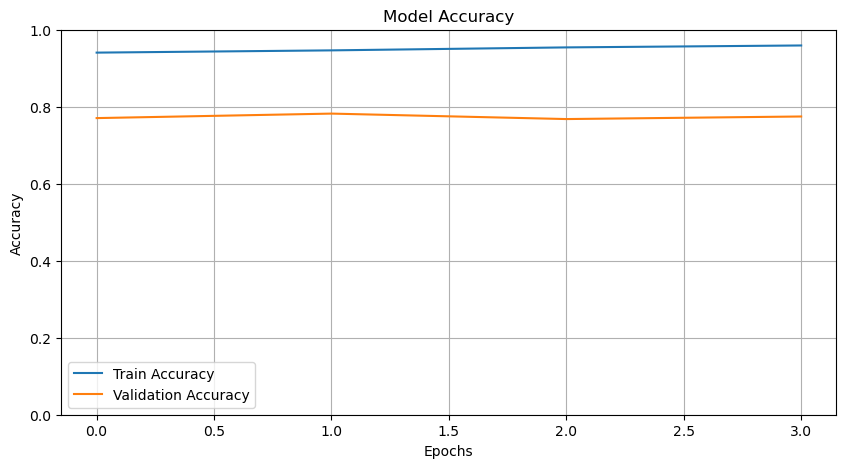

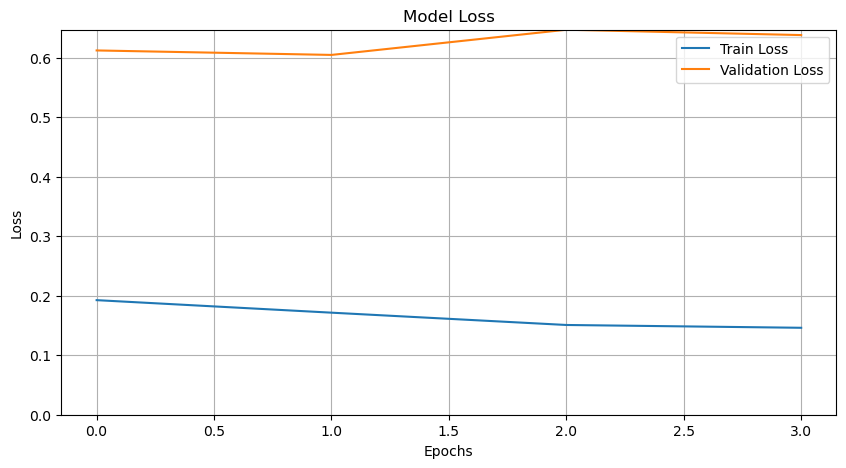

In [103]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis to include 0 and 1
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Set y-axis to include 0
plt.legend()
plt.grid(True)
plt.show()


### **Model Training and Validation Summary**
---

#### **Model Accuracy**
- **Training Accuracy**: The training accuracy consistently improved across epochs, approaching near-perfect values by the final epoch. This indicates the model effectively learned patterns within the training data.
- **Validation Accuracy**: The validation accuracy started lower than the training accuracy but improved steadily before plateauing. The highest validation accuracy achieved was approximately **78.21%**, demonstrating reasonable generalization performance.

#### **Model Loss**
- **Training Loss**: The training loss consistently decreased over the epochs, indicating that the model minimized the error on the training dataset.
- **Validation Loss**: The validation loss initially decreased, reaching a minimum at around **0.6044**, but started to increase slightly toward the later epochs. This behavior suggests potential overfitting, where the model began to memorize training data instead of generalizing to unseen data.

#### **Key Observations**
1. **Training-Validation Gap**:
   - A noticeable gap exists between training and validation accuracy, indicating slight overfitting. Additional regularization techniques (e.g., dropout, L2 regularization) may mitigate this issue.
2. **Stability of Validation Performance**:
   - The validation accuracy remained consistent throughout the training process, suggesting the model's performance is stable.
3. **Impact of Early Stopping**:
   - Early stopping effectively prevented overfitting by halting training before significant degradation in validation performance.


In [109]:
# Load the original test file to get all IDs
original_test_df = pd.read_csv('Data/test.csv')  # Adjust the path as needed

# Re-tokenize and pad the preprocessed test data
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])
X_test_padded = pad_sequences(test_sequences, maxlen=50, padding='post')

# Generate predictions for the preprocessed test data
predictions = model.predict(X_test_padded)
binary_predictions = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame for predictions with IDs from the preprocessed test data
preprocessed_predictions = pd.DataFrame({
    'id': test_df['id'],
    'target': binary_predictions
})

# Align predictions with the original test IDs
# Merge with the original test file to ensure all IDs are included
submission = original_test_df[['id']].merge(
    preprocessed_predictions,
    on='id',
    how='left'
)

# Fill missing predictions with a default value (e.g., 0)
submission['target'] = submission['target'].fillna(0).astype(int)

# Save the submission file
submission_file_name = 'submission.csv'
submission.to_csv(submission_file_name, index=False)

print(f"Submission file '{submission_file_name}' created successfully with {len(submission)} rows!")


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Submission file 'submission.csv' created successfully with 3263 rows!


### **Future Work**
---

#### **1. Enhanced Regularization**
To mitigate overfitting observed in the model:
- Increase dropout rates to further prevent co-adaptation of neurons during training.
- Incorporate or adjust L2 regularization to penalize large weights and improve generalization.

#### **2. Optimizer and Learning Rate Tuning**
- Experiment with different optimizers such as RMSprop or Nadam to assess their impact on convergence and performance.
- Use a learning rate scheduler or implement cyclical learning rates to dynamically adjust the learning rate during training for optimal results.

#### **3. Incorporation of Additional Features**
- Leverage more linguistic features or metadata (e.g., keywords, text sentiment, or location data) to provide the model with richer input for better classification performance.

#### **4. Error Analysis**
- Perform a detailed analysis of misclassified examples to identify recurring patterns, biases, or shortcomings in the model or data preprocessing pipeline.

#### **5. Data Augmentation**
- Use text augmentation techniques, such as paraphrasing or synonym replacement, to artificially expand the training dataset and improve model robustness.

#### **6. Alternative Architectures**
- Experiment with advanced architectures like GRUs, transformer-based models (e.g., BERT or DistilBERT), or hybrid models to potentially outperform the current bidirectional LSTM.

#### **7. Hyperparameter Optimization**
- Conduct a systematic search for hyperparameters such as the number of LSTM layers, hidden units, batch size, and dropout rates using techniques like grid search or Bayesian optimization.

#### **8. Deployment and Scalability**
- Prepare the trained model for deployment in a production environment, ensuring scalability and efficiency.
- Evaluate the model on real-world, unseen data to confirm its applicability and robustness.

#### **9. Ensemble Methods**
- Combine predictions from multiple models (e.g., RNNs, transformer-based models) to create an ensemble for potentially higher accuracy and better stability.

#### **10. Continuous Monitoring and Updating**
- Develop a pipeline for continuous monitoring of the model's performance post-deployment and retrain it periodically with updated data to maintain accuracy over time.

By addressing these recommendations, the model can be further refined, resulting in improved accuracy, robustness, and practical usability.
